## Jinxin Ma 10.28.2017

In this notebook, we will attempt to predict the mean rank of IMO (International Mathematics Olympiad). for 101 countries. The structure of the notebook is as follows:

1. Exploratory Data Analysis

        1.1 Data Overview
        1.2 Missing Value Exploration
        1.3 Training and Test Set Split
        1.4 Correlation Analysis
2. Modeling for Regression

        2.1 Data Preprocessing
        2.2 Inital Model
        2.3 Improved Model using Feature Selection and Dimension Reduction

3. Modeling for Classification

        2.1 Initial Model
        2.2 Model after Changing Split Point of Response
        2.3 Model using K-means to Derive Optimal Split of Response
          
4. Final Discussion and Potential Improvements

In [1]:
# preprocessing and wrangling
from sklearn.preprocessing import Imputer, StandardScaler
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# model
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, ExtraTreesClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.externals import joblib
from sklearn.cluster import KMeans

# pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, log_loss

# display plots in notebook
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 14,
         'axes.titlesize': 20,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
plt.rcParams.update(params)

/Users/jinxin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Exploratory Data Analysis
### 1.1 Data Overview

In [2]:
imo = pd.read_csv('imo.csv')
edustats = pd.read_csv('edustats.csv')
edu_indicators = pd.read_csv('edustats_indicators.csv')

First, let's take a look at the first few rows of each dataset:

**Summary:** 
* There are 101 countries in the data set
* **edustats** has 365620 samples and it's in "long" format so each country has multiple rows. We need to transform it to "wide" format so that each country only corresponds to one row

In [3]:
print imo.shape
print imo.head(5)
print ''

print edustats.shape
print edustats.head(5)
print ''

print edu_indicators.shape
print edu_indicators.head(5)

(101, 2)
  Country.Name  Mean.Rank
0      Albania      79.83
1      Algeria      72.33
2    Argentina      50.00
3      Armenia      43.88
4    Australia      19.75

(365620, 3)
  Country.Name  Indicator.Code      value
0      Albania      UIS.NERA.2  86.577433
1      Albania    UIS.NERA.2.F  86.026518
2      Albania  UIS.NERA.2.GPI   0.987608
3      Albania    UIS.NERA.2.M  87.103674
4      Albania     SE.PRM.TENR  93.175414

(3620, 2)
   Indicator.Code                                     Indicator.Name
0      UIS.NERA.2  Adjusted net enrolment rate, lower secondary, ...
1    UIS.NERA.2.F  Adjusted net enrolment rate, lower secondary, ...
2  UIS.NERA.2.GPI  Adjusted net enrolment rate, lower secondary, ...
3    UIS.NERA.2.M  Adjusted net enrolment rate, lower secondary, ...
4     SE.PRM.TENR  Adjusted net enrolment rate, primary, both sex...


From the table below we see that after transformation, there are 101 samples and 3172 features in the data set. When we have more features than samples, we run into the curse of dimensionality. We will handle this problem in a bit.

In [4]:
# transform the data from long to wide
edustats_wide = edustats.pivot_table(index='Country.Name', \
                               columns='Indicator.Code', \
                               values='value').reset_index(inplace=False)
print edustats_wide.shape
edustats_wide.head(5)

(101, 3172)


Indicator.Code,Country.Name,BAR.NOED.1519.FE.ZS,BAR.NOED.1519.ZS,BAR.NOED.15UP.FE.ZS,BAR.NOED.15UP.ZS,BAR.NOED.2024.FE.ZS,BAR.NOED.2024.ZS,BAR.NOED.2529.FE.ZS,BAR.NOED.2529.ZS,BAR.NOED.25UP.FE.ZS,...,UIS.XUNIT.US.4.FSGOV,UIS.XUNIT.US.56.FSGOV,UIS.XUNIT.USCONST.1.FSGOV,UIS.XUNIT.USCONST.2.FSGOV,UIS.XUNIT.USCONST.23.FSGOV,UIS.XUNIT.USCONST.3.FSGOV,UIS.XUNIT.USCONST.4.FSGOV,UIS.XUNIT.USCONST.56.FSGOV,XGDP.23.FSGOV.FDINSTADM.FFD,XGDP.56.FSGOV.FDINSTADM.FFD
0,Albania,0.960000,1.146667,3.056667,2.300000,1.190000,1.263333,1.056667,1.126667,3.656667,...,NaN,573.089600,1294.434082,324.860687,258.907440,176.931961,NaN,573.089600,0.701640,0.775850
1,Algeria,8.536667,6.533333,34.973333,26.296667,11.343333,7.120000,15.546667,10.040000,44.336667,...,NaN,NaN,486.116252,654.020121,794.764160,1034.755646,NaN,NaN,1.821173,NaN
2,Argentina,0.376667,0.476667,1.956667,1.756667,0.540000,0.600000,0.873333,0.890000,2.423333,...,NaN,1229.963848,1403.893367,1884.196442,1973.816738,2122.200989,NaN,1618.617541,1.626836,0.749662
3,Armenia,0.160000,0.943333,0.646667,0.566667,0.110000,0.236667,0.110000,0.163333,0.786667,...,NaN,260.542546,486.168045,496.355937,582.714193,712.700195,NaN,261.332761,1.333313,0.228587
4,Australia,0.136667,0.153333,1.016667,0.903333,0.186667,0.196667,0.313333,0.310000,1.146667,...,4544.608398,9923.463525,11972.454199,11788.698828,11011.268652,10108.025342,6215.607031,13524.003320,1.699275,0.744217


It's also important to check data type, from the plot below we see that almost all features are numerical.

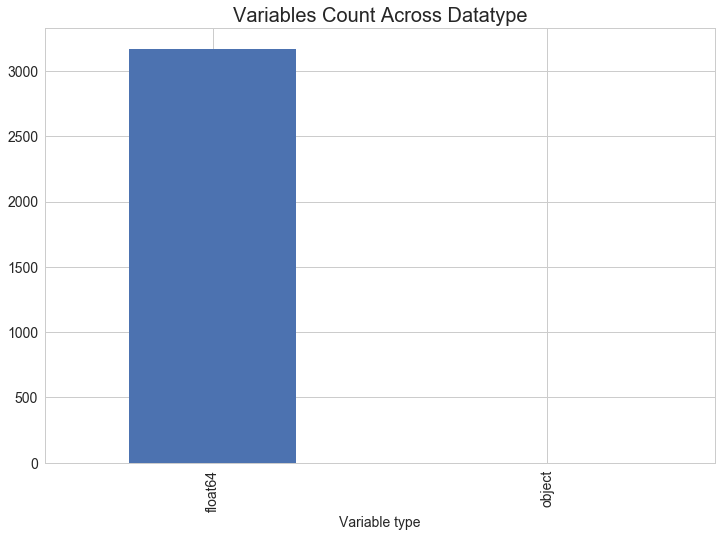

In [5]:
def plot_dtype_distribution(df):
    """
    df: pandas dataframe
    this function plots a distribution of data types from the input dataframe
    """
    
    dataTypeDf = pd.DataFrame(df.dtypes.value_counts()).reset_index().rename(columns={'index':'Variable type', 0:'Count'})    
    dataTypeDf.plot(kind='bar', x='Variable type', y='Count', legend=None, title='Variables Count Across Datatype')

plot_dtype_distribution(edustats_wide)

Let's also look at summary statistics of features. We can see that features are of different scales. We should normalize/standardize them if we want to use linear models or principal component analysis.

In [6]:
edustats_wide.describe()

Indicator.Code,BAR.NOED.1519.FE.ZS,BAR.NOED.1519.ZS,BAR.NOED.15UP.FE.ZS,BAR.NOED.15UP.ZS,BAR.NOED.2024.FE.ZS,BAR.NOED.2024.ZS,BAR.NOED.2529.FE.ZS,BAR.NOED.2529.ZS,BAR.NOED.25UP.FE.ZS,BAR.NOED.25UP.ZS,...,UIS.XUNIT.US.4.FSGOV,UIS.XUNIT.US.56.FSGOV,UIS.XUNIT.USCONST.1.FSGOV,UIS.XUNIT.USCONST.2.FSGOV,UIS.XUNIT.USCONST.23.FSGOV,UIS.XUNIT.USCONST.3.FSGOV,UIS.XUNIT.USCONST.4.FSGOV,UIS.XUNIT.USCONST.56.FSGOV,XGDP.23.FSGOV.FDINSTADM.FFD,XGDP.56.FSGOV.FDINSTADM.FFD
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,...,46.000000,84.000000,81.000000,73.000000,82.000000,76.000000,45.000000,83.000000,84.000000,86.000000
mean,5.038444,4.687037,12.248185,9.885444,5.683741,4.791741,7.181815,5.967222,14.977259,12.004963,...,5939.383170,5014.422605,3949.242702,4851.684348,4827.408515,5530.945210,6629.969017,6080.045777,1.677939,0.893207
std,8.544990,7.509071,14.931370,11.737127,9.619186,7.423891,11.967049,9.166875,18.293580,14.395615,...,14053.987688,6696.599225,5052.398964,5846.536225,6070.120692,6938.768145,13995.552524,8616.212802,0.672556,0.418930
min,0.080000,0.100000,0.176667,0.153333,0.070000,0.076667,0.056667,0.070000,0.106667,0.120000,...,94.867249,90.290766,39.848710,51.972087,30.590290,29.040550,171.727395,121.073287,0.417070,0.180955
25%,0.482500,0.641667,1.935833,1.774167,0.515000,0.601667,0.454167,0.518333,2.029167,1.807500,...,951.863380,809.101412,441.181860,496.355937,545.348226,821.425841,1269.375203,1026.796171,1.243655,0.631653
50%,1.733333,1.995000,6.638333,5.110000,2.043333,1.961667,2.296667,2.273333,7.840000,6.093333,...,2425.035532,1850.873396,1403.893367,1923.322716,1909.202449,2040.562310,2873.496826,2249.654989,1.673550,0.877921
75%,3.884167,4.577500,14.992500,13.278333,6.079167,5.040833,7.952500,7.393333,19.790000,16.027500,...,5437.560897,7418.064899,6843.639997,8937.270368,7730.134917,9613.150963,6876.135254,8144.401164,2.058260,1.063856
max,43.713333,38.043333,63.956667,50.196667,52.410000,40.130000,60.610000,45.000000,73.586667,58.113333,...,87936.401042,30827.647380,25239.483073,23587.346191,28208.284961,33546.617969,83716.473958,45888.410156,3.764303,2.126210


Finally, let's look at the distribution of the response variable **Mean.Rank**. There doesn't seem to be any outliers. The distribution is neither normal nor uniform.

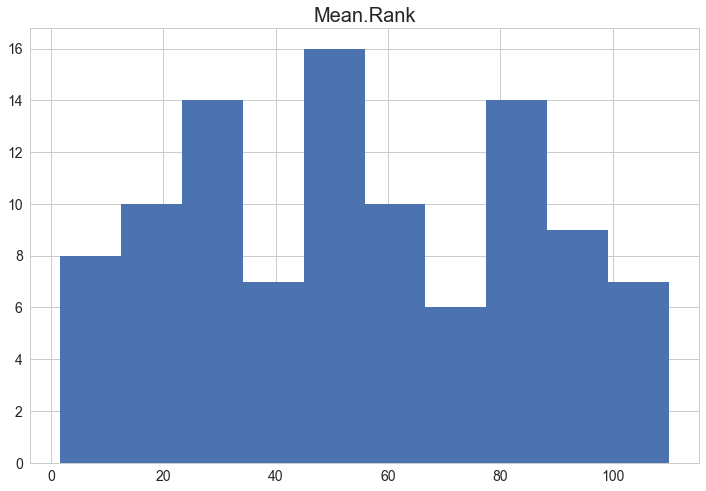

In [7]:
imo.hist();

### 1.2 Missing Value Information
After getting an initial sense of the data, now let's check if there are missing values in the data.

In [8]:
def get_missing_info(df):
    """
    df: pandas dataframe
    return: dataframe of count and percentage of missing value for 
            each column in the input dataframe
    """
    missing_ct = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'Feature Name', 0:'Count'})
    missing_ct['Percentage'] = (missing_ct['Count'] / len(df)) * 100
    return missing_ct.sort_values('Count', ascending=False)

By looking at the top 25 columns with most missing values, we found that these columns have 99% of values being missing. Features like this won't provide any information/usefullness in modeling. We should remove such features.

In [9]:
get_missing_info(edustats_wide).head(25)

,Indicator.Code,Count,Percentage
658,LO.EGRA.CWPM.ZERO.NZE.2GRD,100,99.009901
711,LO.EGRA.ORF.ARB.3GRD,100,99.009901
1613,SABER.HLTH.GOAL3,100,99.009901
1612,SABER.HLTH.GOAL2,100,99.009901
1611,SABER.HLTH.GOAL1,100,99.009901
712,LO.EGRA.ORF.AST.2GRD,100,99.009901
713,LO.EGRA.ORF.DAG.2GRD,100,99.009901
714,LO.EGRA.ORF.DAGB.2GRD,100,99.009901
771,LO.EGRA.READ.SPN.ADV.4GRD,100,99.009901
715,LO.EGRA.ORF.DAN.2GRD,100,99.009901


I decided to remove features with more 5% missing values. This means for each feature, we only allow at most 5-6 missing values. I'm being strict here because we only have 101 samples.

After feature removal, the number of features is reduced from 3172 to 691. We have reduced the dimension of the dataset by a lot.

In [10]:
edustats_dropna = edustats_wide.dropna(axis=1, thresh=0.95*len(edustats_wide))
print edustats_dropna.shape

(101, 691)


## 1.3 Training and Test Set Split

Before we continue our exploratory data analysis, let's split the raw data set into training and test. In this way, the test set is treated as unseen data which we will use to test model performance.

The training set has 80 samples - 80% of the samples from the unsplitted data set. The test set has the rest 20% samples.

In [11]:
# join label (mean ranking) and features
merged_df = imo.merge(edustats_dropna, how='inner', on='Country.Name')

X_train, X_test, y_train, y_test = train_test_split(merged_df.drop('Mean.Rank', axis=1), merged_df['Mean.Rank'], \
                                                    test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), \
                                   y_train.reset_index(drop=True), y_test.reset_index(drop=True)
    
data_with_y = pd.concat([y_train, X_train], axis=1) # this dataframe facilitates exploratory data analysis
print X_train.shape, X_test.shape

(80, 691) (21, 691)


## 1.4 Correlation Exploration

From the table below, we can see that many features have above 0.4 (or below -0.4) correlation with **Mean.Rank**. However, many of these features belong to the same feature group. For example, features named as **PRJ.ATT.xxx** all belong to **Wittgenstein Projection: Percentage of the population age xx-xx by highest level of educational attainment**. As a result, we might also want to see if features are correlated with each other.

In [12]:
corr_matrix = data_with_y.corr()
corr_matrix['Mean.Rank'].sort_values(ascending=False).head(15)

Mean.Rank              1.000000
SP.POP.0014.TO.ZS      0.506133
PRJ.ATT.1519.S1.FE     0.455383
PRJ.ATT.1519.S1.MF     0.450306
PRJ.ATT.2024.S1.FE     0.446034
PRJ.ATT.1519.S1.MA     0.445480
PRJ.ATT.1519.NED.MA    0.444523
PRJ.ATT.2024.S1.MF     0.441554
PRJ.ATT.2024.S1.MA     0.431631
PRJ.ATT.4064.NED.MA    0.424922
PRJ.ATT.2529.NED.MA    0.422732
PRJ.ATT.2064.NED.MA    0.419293
PRJ.ATT.2024.NED.MA    0.418941
PRJ.ATT.4064.NED.MF    0.416280
PRJ.ATT.25UP.NED.MA    0.413297
Name: Mean.Rank, dtype: float64

In [13]:
corr_matrix['Mean.Rank'].sort_values(ascending=False).tail(15)

SE.SEC.ENRR.MA       -0.430124
PRJ.MYS.1519.FE      -0.432764
PRJ.MYS.1519.MA      -0.432866
PRJ.MYS.1519.MF      -0.436973
UIS.TE_100000.56     -0.444438
PRJ.ATT.1519.3.MA    -0.447346
SE.TER.ENRR.MA       -0.459361
UIS.SLE.56.M         -0.467207
PRJ.ATT.1519.3.MF    -0.475149
PRJ.ATT.1519.3.FE    -0.484438
UIS.TE_100000.56.M   -0.491650
PRJ.MYS.0T19.MA      -0.498794
PRJ.MYS.0T19.FE      -0.511435
PRJ.MYS.0T19.MF      -0.518640
SP.POP.1564.TO.ZS    -0.560313
Name: Mean.Rank, dtype: float64

When features are correlated with each other, we have multicolinearity. As can be seen from the correlation matrix plot below, **PRJ.ATT.xxx** features are highly correlated with each other.

It's not as big of an issue in predictive modeling as in statistical modeling meaning we care more about how the model predicts versus whether coefficients are statiscially significant. In ideal cases we do want to remove multicolinear features, but for this data challenge I chose not to due to time limit.

To further reduce dimensionality let's remove features for which absolute value of correlation with **Mean.Rank** is below 0.3. I assume that they won't be particularly predictive of the **Mean.Rank**

In [14]:
def corr_mat_heatmap(df):
    """
    df: pandas dataframe
    this function plots a correlation matrix heatmap based on the input dataframe
    """
    corr_matrix = df.corr()
    
    sns.set(style='white', font_scale=1.4)
    f, ax = plt.subplots(figsize=(14, 9))
    
    # Create a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = sns.diverging_palette(300, 50, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, mask=mask, annot=True, annot_kws={'size': 12})  
    ax.set_title('Correlation Matrix Heatmap')

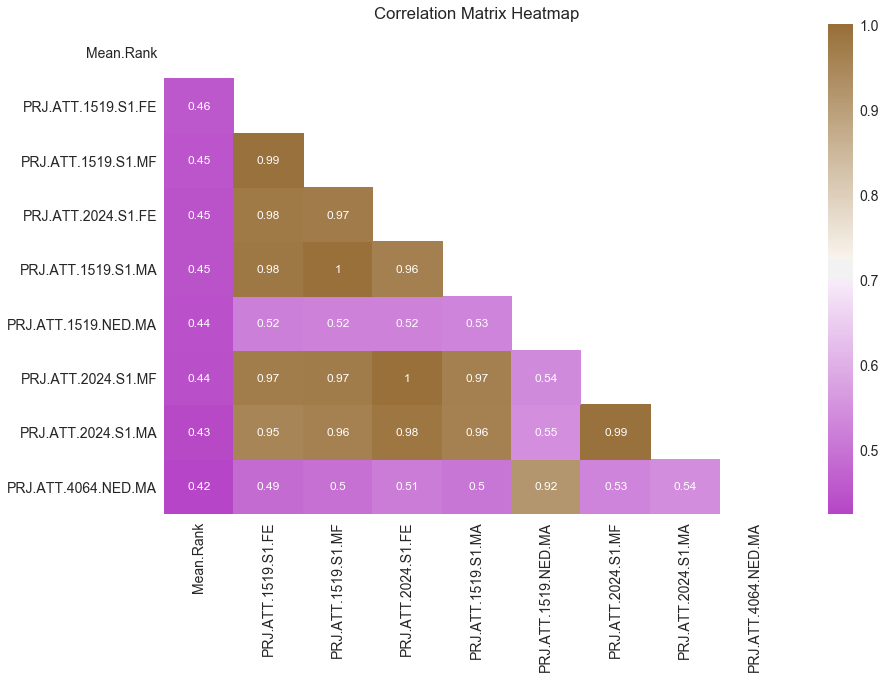

In [15]:
attributes = ['Mean.Rank',
             'PRJ.ATT.1519.S1.FE',
             'PRJ.ATT.1519.S1.MF',
             'PRJ.ATT.2024.S1.FE',
             'PRJ.ATT.1519.S1.MA',
             'PRJ.ATT.1519.NED.MA',
             'PRJ.ATT.2024.S1.MF',
             'PRJ.ATT.2024.S1.MA',
             'PRJ.ATT.4064.NED.MA']

corr_mat_heatmap(data_with_y[attributes])

We can also visualize the relationship of features and response variable using plots. Let's first look at a scatter plot of **Population, ages 15-64 (% of total)** vs **Mean.Rank**. It seems that as a country has more population age 15-64, the mean rank goes higher. This association doesn't seem to have a strong real-world significance because IMO ranking could be more relevant to education instead of population.

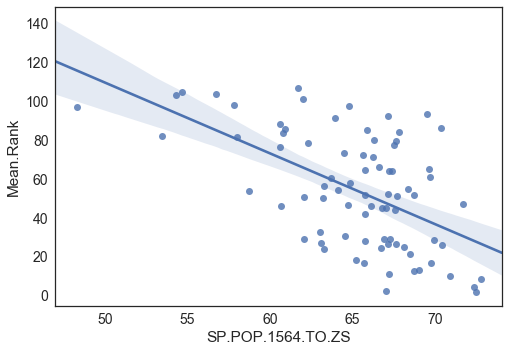

In [16]:
sns.regplot(x='SP.POP.1564.TO.ZS', y='Mean.Rank', data=data_with_y)

By looking at another scatter plot below, we see that as percentage of population age 15-19 who didn't complete primary school goes up, the **Mean.Rank** also goes lower. This seems to make sense because . However, we need to avoid the trap of mixing up correlation with causal relationship. The association here doesn't tell which causes which.

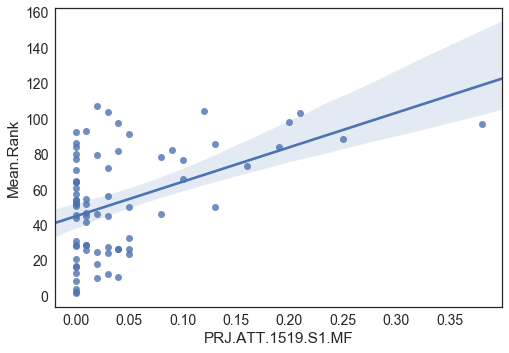

In [17]:
sns.regplot(x='PRJ.ATT.1519.S1.MF', y='Mean.Rank', data=data_with_y)

After correlation analysis, let's now filter out features who are not very correlated with **Mean.Rank**, we are left with 197 features. However, the number of features are still more than the number of samples which means that we can easily overfit the data. We will handle this issue later on.

In [18]:
corr_df = pd.DataFrame(corr_matrix['Mean.Rank'].\
                    sort_values(ascending=False)). \
                    reset_index()
    
high_corr_df = corr_df[abs(corr_df['Mean.Rank']) > 0.3]

In [19]:
X_train2 = X_train[list(high_corr_df['index'])[1:]] # only take out highly correlated features
X_test2 = X_test[list(high_corr_df['index'])[1:]]
print ('Training data dimension: ', X_train2.shape)
print ('Test data dimension: ', X_test2.shape)

('Training data dimension: ', (80, 197))
('Test data dimension: ', (21, 197))


## 2. Modeling for Regression

In this section, we will use the raw **Mean.Rank** to build several regression models.

### 2.1 Data Preprocessing
For this dataset, there are mainly two steps for data preprocessing: missing value imputation and feature standardization. Let's use the pipeline class in Python to complete these two tasks. Pipeline allows us to pre-process the data more systematically with less code. Below is a helper function class called FeatureSelector. With fit and tranform methods written for the class, we can use it in pipeline just like the built-in class of Scikit-learn.

In [20]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    this class allows for subsetting data based on column names
    it can be used in Scikit-learn's pipeline
    """
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_names].values

Preprocess the training data in a pipeline:

In [21]:
features = X_train2.columns
pipeline = Pipeline([
        ('feature_selector', FeatureSelector(features)),
        ('imputer', Imputer(strategy="median")),
        ('feature_scaler', StandardScaler()),])

X_train_processed = pipeline.fit_transform(X_train2)

### 2.2 Initial Model

After data-preprocessing, now let's run some initial models with alll 197 features included. After we get the best of performer, we can stick to it for the rest modeling process. In practice though, we might want to have a main model, but keep track of performances of alternative models. After all, we never know if winner is always the winner.

In [22]:
def cross_validation_rmse(model, data, label):
    """
    data: training data
    label: response variable
    
    this function performs a 3-fold cross validation and prints out the RMSE scores
    """
    scores = cross_val_score(model, data, label, scoring="neg_mean_squared_error", cv=3)
    rmse_scores = np.sqrt(-scores)
    
    print('RMSE from 3-fold cross validation:', rmse_scores)
    print('Mean RMSE of 3-fold cross validation:', rmse_scores.mean())
    print('RMSE Standard deviation:', rmse_scores.std())
    print ''

We will test linear regression, random forest, extra trees, gradient boosting, and XGBoost. We will use cross validation to check their performance on the training set. Cross validation can usually prevent the model from overfitting the data. As this dataset has rather small number of samples, we will use 3-fold cross validation.

To evaluate the models we will use RMSE (root mean square error), it's defined as $\sqrt{(y_{response} - y_{predict})^2}$.

Alternatively, we can use MAE (mean absolute error) to evaluate a regression model. MAE is less affected by outliers, however, we want to avoid the effect of outliers, so we will stick to RMSE for the rest modeling process.

From the results below, we see that extra trees regressor has the best performance. Let's use it from now on.

In [23]:
algos = [LinearRegression(), RandomForestRegressor(random_state=0),
         ExtraTreesRegressor(random_state=0), GradientBoostingRegressor(random_state=0),
         XGBRegressor()]

for algo in algos:
    cross_validation_rmse(algo, X_train_processed, y_train)

('RMSE from 3-fold cross validation:', array([ 40.15971988,  78.42684262,  29.54951822]))
('Mean RMSE of 3-fold cross validation:', 49.378693573078351)
('RMSE Standard deviation:', 20.991908233908593)

('RMSE from 3-fold cross validation:', array([ 18.18177103,  24.6977021 ,  22.69437455]))
('Mean RMSE of 3-fold cross validation:', 21.857949228021763)
('RMSE Standard deviation:', 2.7250743008279423)

('RMSE from 3-fold cross validation:', array([ 21.40852538,  22.54969672,  17.98745731]))
('Mean RMSE of 3-fold cross validation:', 20.648559801035603)
('RMSE Standard deviation:', 1.9384990532442097)

('RMSE from 3-fold cross validation:', array([ 18.87485388,  25.81674794,  19.82701932]))
('Mean RMSE of 3-fold cross validation:', 21.506207045702368)
('RMSE Standard deviation:', 3.0726998816076661)

('RMSE from 3-fold cross validation:', array([ 17.4705412 ,  26.66423622,  18.14675023]))
('Mean RMSE of 3-fold cross validation:', 20.760509215651414)
('RMSE Standard deviation:', 4.183683307

### 2.3 Feature Selection and Dimension Reduction

In the previous section, we trained the model using all 193 features. When there are more features than samples, the model tend to overfit the data. In this section we will use several methods for feature selection and dimention reduction. The purpose is to see if we can build a robust model with less features.

#### 2.31 Feature Importance from Extra Trees

First, let's use feature importance from extra trees to select the top 20 most important features. In Scikit-learn, the feature importance of extra trees is directly related how frequent the data is split on a node/feature, and how deep this node appears in a tree. Feature importance can usually give us good insights which features are predictive.

In [24]:
def indices_of_top_k(arr, k):
    """
    this function is used with TopFeatureSelector
    """
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


class TopFeatureSelector(BaseEstimator, TransformerMixin):
    """
    this class allows for subsetting data based on feature importance
    """
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

From the result below we see that by using the top 20 important features, we reduce the RMSE from 20.65 to 19.49.

In [25]:
extra_reg = ExtraTreesRegressor(random_state=0)
extra_reg.fit(X_train_processed, y_train)

final_pipeline = Pipeline([
    ('preparation', pipeline),
    ('feature_selection', TopFeatureSelector(extra_reg.feature_importances_, 20))
])

X_train_final = final_pipeline.fit_transform(X_train2)
cross_validation_rmse(ExtraTreesRegressor(random_state=0), \
                                                X_train_final, y_train)

('RMSE from 3-fold cross validation:', array([ 20.70238157,  19.95048862,  17.83000168]))
('Mean RMSE of 3-fold cross validation:', 19.494290622539136)
('RMSE Standard deviation:', 1.2162042088559482)



Let's also plot the feature importance. From the plot below we see that the top 1 important feature is **Percentage of the population age 15-19 by highest level of educational attainment. Incomplete Primary. Total**. More interestingly, almost all important features belong to the **PRJ.ATT.xxx** feature group. This is consistent with what we saw in the correlation analysis.

In [26]:
def feature_importance_plot(importance_list, col_list, top_n=10):
    """
    importance_list: a list of feature importance
    col_list: a list of column names matching the importance list
    
    this functions draw a plot of feature importance
    """
    importance_df = pd.DataFrame({'feature_importance': importance_list[:top_n], \
                                  'feature_name': col_list[:top_n]}).\
                    sort_values('feature_importance', ascending=False)
    sns.barplot(x='feature_importance', y='feature_name', data=importance_df, color="b")

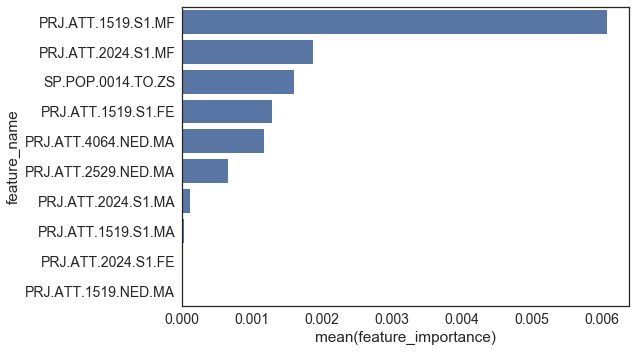

In [27]:
feature_importance_plot(extra_reg.feature_importances_, X_train2.columns)

#### 2.32 Recursive Feature Elimination

Now let's use recursive feature elimination (RFE) to perform feature selection. As per documentation of Scikit-learn, RFE does the following job:

Given an external estimator that assigns weights to features (e.g., feature importance), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

The difference between the previous method and RFE is that previously, we fit the model to the whole dataset only once and we then selected 20 important features. On the other hand, RFE will fit the model multiple times and remove the least important feature each time until we have 20 left (I chose to keep 20 features so we can compare two methods). As a result, the final feautres are different, we see less **PRJ.ATT** features and have some other features.

In [28]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=ExtraTreesRegressor(random_state=0), n_features_to_select=20, step=1)
rfe.fit(X_train_processed, y_train)

print "Features sorted by their rank:"
print sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), \
                 X_train2.columns))[:20]

Features sorted by their rank:
[(1.0, 'IT.CMP.PCMP.P2'), (1.0, 'NY.GDP.MKTP.CD'), (1.0, 'NY.GNP.MKTP.PP.CD'), (1.0, 'PRJ.ATT.1519.3.FE'), (1.0, 'PRJ.ATT.1519.3.MF'), (1.0, 'PRJ.ATT.2039.NED.MA'), (1.0, 'PRJ.ATT.25UP.NED.MF'), (1.0, 'PRJ.POP.2529.4.MA'), (1.0, 'PRJ.POP.ALL.4.MA'), (1.0, 'SE.PRM.TCHR.FE.ZS'), (1.0, 'SE.SEC.ENRL.GC'), (1.0, 'SE.TER.ENRL.FE'), (1.0, 'SP.POP.0014.TO.ZS'), (1.0, 'SP.POP.GROW'), (1.0, 'UIS.E.02.PU'), (1.0, 'UIS.OE.56.40510'), (1.0, 'UIS.SLE.1.F'), (1.0, 'UIS.SLE.23.F'), (1.0, 'UIS.SLE.23.M'), (1.0, 'UIS.SLE.56.M')]


From the result below, we see that the model trained on feautres derived from RFE has better performance. The RMSE is further reduced from 19.49 to 19.15.

In [29]:
selected_features = list(np.array(X_train2.columns)[np.where(rfe.ranking_==1)])
pipeline2 = Pipeline([
        ('feature_selector', FeatureSelector(selected_features)),
        ('imputer', Imputer(strategy="median")),
        ('feature_scaler', StandardScaler()),])

X_train_rec = pipeline2.fit_transform(X_train2)
cross_validation_rmse(ExtraTreesRegressor(random_state=0), \
                      X_train_rec, y_train)

('RMSE from 3-fold cross validation:', array([ 18.01374047,  23.13852297,  16.3117333 ]))
('Mean RMSE of 3-fold cross validation:', 19.154665580542247)
('RMSE Standard deviation:', 2.9014418118943053)



#### 2.33 Principal Component Analysis

Finally, let's use PCA for dimension reduction. Note that, we are not performing feature selection here, we simply compress the data into a few principal components and hope it can improve the model performance.

In [30]:
from sklearn.decomposition import PCA

rmse = []
for i in xrange(1,21):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train_processed)
    scores = cross_val_score(ExtraTreesRegressor(random_state=0), \
                                                 X_train_pca, y_train, \
                                                 scoring="neg_mean_squared_error", cv=3)
    rmse_scores = np.sqrt(-scores)
    rmse.append(np.mean(rmse_scores))

From the result below, we see that when the number of components is 10, we have the lowest RMSE. However, this RMSE is the worse than that of previous methods.

RMSE from PCA: 21.6729188222


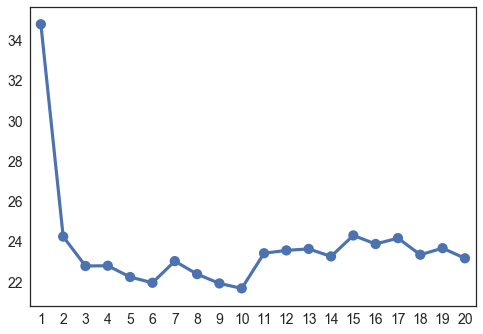

In [31]:
print "RMSE from PCA: " + str(rmse[9])
sns.pointplot(range(1, 21), rmse)

#### 2.34 Modeling Summary

We have used three methods for feature selection or dimension reduction.
1. Feature importance method gave us a RMSE of 19.49.
2. Recursive feature elimination gave us a RMSE of 19.15 - the best among three. We also see more diversity in selected features. As a result, let's use this model for prediction.
3. Principal Component Analysis gave us a RMSE of 21.57. In practice it won't work too well if features are highly correlated with each other.

### 2.4 Predict on Test Set

Finally, let's predict on the test set using features selected from RFE. The RMSE on the test set is 16.57. It's lower than the training RMSE. In practice, this doesn't seem to the the usual case, the RMSE on the test set should be higher than the training set. For this dataset though, we have very few samples in the test set which can be the reason.

In [32]:
X_test_rec = pipeline2.transform(X_test2)

extra_reg = ExtraTreesRegressor(random_state=0)
extra_reg.fit(X_train_rec, y_train)
y_test_pred = extra_reg.predict(X_test_rec)
print 'RMSE on test set is: ' + str(np.sqrt(mean_squared_error(y_test, y_test_pred)))

RMSE on test set is: 16.5709677376


Let's take a deeper dive and compare the true values and predicted values. We see from the table below that the model generalizes "ok" on most samples, but it didn't do a good job for some points, for example, for ranking 76 (Ireland), the predicted ranking is 39. My reasoning is that, ensemble methods such as random forest and extra trees try to make predictions based on decision rules. Since Ireland is a developed country and has great educational attributes (e.g. more educated population), it's easy for the model to predict a good ranking for it because other developed countried with similar educational attributes often have good rankings. To counter this kind of problem, we need feature engineering or even more feautres (such as the historical ranking of a country).

In [33]:
result = pd.DataFrame({'True IMO Ranking':y_test, 'Predicted IMO Ranking':y_test_pred})
result.sort_values('True IMO Ranking')

,Predicted IMO Ranking,True IMO Ranking
17,11.780,5.50
4,20.729,11.25
14,33.452,15.25
15,37.578,19.75
19,18.542,21.63
7,32.179,22.00
13,52.323,36.88
6,37.864,37.38
0,59.088,44.75
11,40.390,45.13


## 3. Modeling for Classification

Now let's switch our gear a bit and turn this regression problem into a classification one. Let's try to predict if a country has a high, medium, and low ranking. 

### 3.1 Initial Model

For the first model, let's consider the following interval:

* High: ranking <= 30
* Medium: ranking 30 - 60
* Low: ranking > 60

From the histogram below, we see a relatively balanced class distribution.

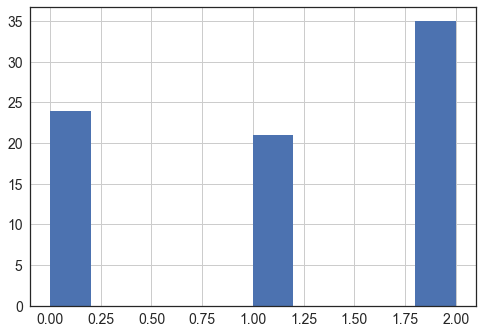

In [34]:
def response_bin(value):
    if value <= 30:
        return 0
    elif value > 30 and value <= 60:
        return 1
    elif value > 60:
        return 2

y_train_cat = y_train.apply(response_bin)
y_test_cat = y_test.apply(response_bin)
y_train_cat.hist()

This time, let's use log loss to verify our cross-validation result. Los loss punishes more on mis-classified samples and is used in many kaggle competitions.

In [35]:
def cross_validation_logloss(model, data, label):
    """
    data: training data
    label: response variable
    
    this function performs a 3-fold cross validation and prints out the RMSE scores
    """
    logloss = cross_val_score(model, data, label, scoring="neg_log_loss", cv=3)
    
    print('Log loss from 3-fold cross validation:', -logloss.mean())
    print ''

Since we got the best feature set for regression using recursive feature elimination, let's use RFE for classification too. The final feature set is somewhat similar to that of the regression.

In [36]:
rfe = RFE(estimator=ExtraTreesClassifier(random_state=0), n_features_to_select=20, step=1)
rfe.fit(X_train_processed, y_train_cat)

print "Features sorted by their rank:"
print sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), \
                 X_train2.columns))[:20]

Features sorted by their rank:
[(1.0, 'NY.GDP.MKTP.KD'), (1.0, 'NY.GDP.MKTP.PP.CD'), (1.0, 'NY.GDP.MKTP.PP.KD'), (1.0, 'NY.GNP.MKTP.CD'), (1.0, 'PRJ.ATT.15UP.3.FE'), (1.0, 'PRJ.ATT.2024.3.MA'), (1.0, 'PRJ.ATT.2024.3.MF'), (1.0, 'PRJ.ATT.60UP.NED.MF'), (1.0, 'PRJ.ATT.ALL.3.FE'), (1.0, 'PRJ.MYS.2039.FE'), (1.0, 'PRJ.POP.ALL.3.FE'), (1.0, 'PRJ.POP.ALL.4.FE'), (1.0, 'SE.PRM.DURS'), (1.0, 'SE.SEC.ENRL.GC'), (1.0, 'SE.SEC.ENRR.LO.MA'), (1.0, 'UIS.E.2.GPV.F'), (1.0, 'UIS.GER.1T6.F'), (1.0, 'UIS.SLE.1.F'), (1.0, 'UIS.SLE.1.GPI'), (1.0, 'UIS.TE_100000.56')]


In [37]:
selected_features = list(np.array(X_train2.columns)[np.where(rfe.ranking_==1)])
pipeline2 = Pipeline([
        ('feature_selector', FeatureSelector(selected_features)),
        ('imputer', Imputer(strategy="median")),
        ('feature_scaler', StandardScaler()),])

X_train_rec = pipeline2.fit_transform(X_train2)
X_test_rec = pipeline2.transform(X_test2)

We have a log loss of 2.01 from cross validation

In [38]:
extra_class = ExtraTreesClassifier(random_state=0)
cross_validation_logloss(extra_class, data=X_train_rec, label=y_train_cat)

('Log loss from 3-fold cross validation:', 2.0100936100964937)



### 3.2 Model after Changing Splitting Point of Response

This time, let's consider the following split:

* High: ranking <= 20
* Medium: ranking 20 - 50
* Low: ranking > 50

In [39]:
def response_bin(value):
    if value <= 20:
        return 0
    elif value > 20 and value <= 50:
        return 1
    elif value > 50:
        return 2

y_train_cat = y_train.apply(response_bin)
y_test_cat = y_test.apply(response_bin)

The log loss dropped from 2.01 to 1.96. Is that the best split though? If not, how do we find the best one?

In [40]:
extra_class = ExtraTreesClassifier(random_state=0)
cross_validation_logloss(extra_class, data=X_train_rec, label=y_train_cat)

('Log loss from 3-fold cross validation:', 1.9610563859208936)



### 3.3 Use K-means to Cluster Response Variable

In practice, when we don't know how to choose the splitting points for the response variable, we can use clustering technique. Using k-means clustering, we see the splitting points become 32.63 and 65.88. This is similar to our first model.

In [41]:
kmeans = KMeans(n_clusters=3, random_state=0)
y_train_cluster = kmeans.fit_predict(y_train.values.reshape(-1, 1))
result = pd.DataFrame({'True IMO Ranking':y_train, 'K-means cluster':y_train_cluster})
result.sort_values('True IMO Ranking')

,K-means cluster,True IMO Ranking
33,1,1.63
49,1,2.38
29,1,4.13
19,1,8.38
69,1,10.00
42,1,10.88
5,1,12.63
4,1,13.13
8,1,16.38
58,1,16.63


Using the splitting points derived from k-means, we have a log loss of 1.92 - the lowest so far. Seems that clustering indeed helps here.

In [42]:
extra_class = ExtraTreesClassifier(random_state=0)
cross_validation_logloss(extra_class, data=X_train_rec, label=y_train_cluster)

('Log loss from 3-fold cross validation:', 1.9256376052466966)



### 3.4 Predict on Test Set

Finally, let's predict on the test set. We will use confusion matrix, recall, precision, f1 score to evaluate our model.

In [43]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

From the table below, we see that the average precision, recall, and f1 scores are all above 0.7.

In [44]:
extra_class.fit(X_train_rec, y_train_cluster)
y_test_cluster = kmeans.predict(y_test.values.reshape(-1, 1))
y_test_pred = extra_class.predict(X_test_rec)
print classification_report(y_test_cluster, y_test_pred)

             precision    recall  f1-score   support

          0       0.80      0.50      0.62         8
          1       0.78      1.00      0.88         7
          2       0.57      0.67      0.62         6

avg / total       0.73      0.71      0.70        21



We can also visualize the predictions using a confusion matrix. This lets us know that the model did a good job for the **medium ranking** class (class 1). We can conclude that the model generalizes well. 

[[4 1 3]
 [0 7 0]
 [1 1 4]]


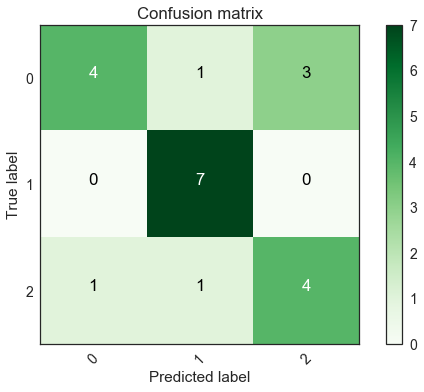

In [45]:
cnf_matrix = confusion_matrix(y_test_cluster, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2],
                      title='Confusion matrix')

## 4. Final Discussion and Future Improvements

We built predictive models to predict the mean IMO rank and the levels/ranges of the rank using both regression and classification techniques. Extra trees regressor/classifier was used throughout the modeling process. Recursive feature elimination was used to select predictive features.

We used RMSE, precision, recall, etc. to evaluate the model. The conclusion is that the models generalize well on the unseen data (test data). However, the performance can be further improved. I have listed several areas for potential improvements:

* Feature engineering: for this exercise, I focused more on feature selection and dimension reduction and didn't perform feature engineering which I'd love to do in the future. For example, we can have a feature that indicate the continent where a country belongs to
* External data source: I'd like to see if we can find more available data that might improve the model. For example, health indicators can be helpful
* Data quality: I'd like to check if feature have outliers to see if the model performance can be further improved
* Hyper-parameter tuning: since the default paramter values are usually sufficent, I didn't tune the hyper-parameters. In practice, tuning parameters can further improve the model performance
* Modeling technique: I have mostly focused on ensemble method for its generally good performance. However, with proper feature preprocessing, linear models can also have good performance. I'd like to try out factor analysis for dimension reduction and use linear models to make predictions. This will especially be helpful if we want to see which factor/feature is statistically significant. Also, it's easier to interpret
* Better correlation analysis: I'd like to test if the correlation coefficients are statistically significant which I didn't have time to do for this exercise
* Data visualization: I used a few plots to visualize the relationship between a few features and the mean ranking. I'd like to use more visualizations or even an interactive shiny app to get insights of the data. This can be helpful for data transformation. For example, if some features are skewed, using a log transformation can mitigate the problem.